<a href="https://colab.research.google.com/github/lauraliron/ufv_visualizacion/blob/main/Ejercicios%20Clase/Clase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 1 Visualización
##Laura Lirón Carrión


En esta práctica, nuestro objetivo es analizar a fondo una base de datos de ventas y evaluar la distribución de las mismas y la precisión de las predicciones de ventas para distintas bebidas en diferentes países. Utilizando un dataset con datos de ventas reales y pronósticos.

###Instalación de librerias y carga de datos

Lo primero que haremos es instalar todas las librerias necesarias.


In [4]:
pip install plotly_express

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import matplotlib.cm as cm
from statsmodels.tsa.seasonal import seasonal_decompose

###Análisis de datos


Una vez cargado el archivo CSV, realizamos una exploración inicial para obtener una vista rápida de los datos, lo cual nos permite comprender el contenido y las primeras cinco filas de nuestro conjunto de datos.
El objetivo de esta vista inicial es identificar las columnas que contiene el dataset y observar los tipos de datos de cada columna.

In [6]:
df = pd.read_csv('datos_ejercicio_ventas.csv')
df.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491


Eliminamos ventas negativas.

In [7]:
df = df[df['AMOUNT'] >= 0]

Comprobamos si hay filas duplicadas en la base de datos.

In [8]:
num_duplicadas = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicadas}")

Número de filas duplicadas: 663


Mostramos algunas de las filas duplicadas

In [9]:
filas_duplicadas = df[df.duplicated(keep=False)]
num_grupos_duplicados = filas_duplicadas.duplicated().sum()
print(filas_duplicadas)

             COUNTRY       SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
1      Great Britain    Lipton (L3)  2023     12  AI_forecast  AI_P10F   
3      Great Britain       7up (L3)  2024     12  AI_forecast  AI_P10F   
13     Great Britain       7up (L3)  2024      7  AI_forecast  AI_P05F   
26     Great Britain       7up (L3)  2024      2  AI_forecast  AI_P10F   
35           Hungary       7up (L3)  2025      4  AI_forecast  AI_P12F   
...              ...            ...   ...    ...          ...      ...   
18590        Hungary       7up (L3)  2025      1  AI_forecast  AI_P12F   
18606  Great Britain  7up Free (L3)  2024      8  AI_forecast  AI_P03F   
18631  Great Britain       7up (L3)  2024     10  AI_forecast  AI_P11F   
18649  Great Britain    Lipton (L3)  2024      5  AI_forecast  AI_P11F   
18650  Great Britain    Lipton (L3)  2024      5  AI_forecast  AI_P09F   

       FORECAST_YEAR        AMOUNT  
1             2023.0  5.600306e+05  
3             2023.0  3.632245e+05  


Ahora eliminamos las filas que estan duplicadas y conservaremos solo la primera aparición. Luego mostramos el numero de filas final con el que trabajaremos.

In [10]:
df_sin_duplicados = df.drop_duplicates()
df.drop_duplicates(inplace=True)

Al no comprender del todo la variable scenario ya que sale siempre el mismo valor en la tabla anterior, vamos a ver los tipos que pueden darse.

In [11]:
valores_unicos_scenario = df['SCENARIO'].unique()
print("Valores únicos en SCENARIO:", valores_unicos_scenario)

Valores únicos en SCENARIO: ['AI_forecast' 'actual']


Es decir, que la variable 'SCENARIO' hablara de valores predichos y valores actuales o reales.

Una vez conocemos la informacion que contiene el conjunto de datos sobre las ventas realizadas y las previsiones de ventas explicaremso las variables para tenerlas claras durante todo el proceso de análisis.

**COUNTRY**: Representa el país en el que se realiza una predicción de venta.

**SUBBRAND**: Hace referencia a diferentes marcas de bebidas.

**YEAR**: Indica el año en el que se registra la previsión.

**MONTH**: Señala el mes en el que se registra la previsión.

**SCENARIO**: Describe el tipo de dato representado en la fila, como "AI_forecast" (previsión) o "actual" (ventas reales).

**FORECAST**: Muestra el valor de previsión de ventas, es decir, la cantidad estimada para ese país, sub-marca, año y mes. Esta columna es clave para analizar qué tan precisas fueron las previsiones en comparación con las ventas reales.

**FORECAST_YEAR**: Indica el año en que se realizó la previsión. Por ejemplo, si en 2022 se hizo una previsión para el 2023, FORECAST_YEAR sería 2022 y YEAR sería 2023.

**AMOUNT**: Valor numérico de la previsión de ventas para el país, sub-marca, año y mes especificados.


Una de las primeras tareas al explorar un conjunto de datos es saber cuántas filas y columnas contiene, ya que esto nos da una idea de la escala y nos ayuda a planificar el análisis. En este caso, vamos a calcular y mostrar el número de filas.

In [12]:
num_filas = df.shape[0]
print(f"El número de filas es {num_filas}")

El número de filas es 17993


Acontinuación, analizaremos la cantidad de valores NaN en cada columna.


In [13]:
nan_count = df.isna().sum()
print(nan_count)

COUNTRY            0
SUBBRAND           0
YEAR               0
MONTH              0
SCENARIO           0
FORECAST         890
FORECAST_YEAR    890
AMOUNT             0
dtype: int64


Es posible que los registros con NaN en FORECAST y FORECAST_YEAR representen ventas reales (actuals), en cuyo caso, podría tener sentido conservar estas filas para otro tipo de análisis, como estudiar los resultados reales por sí mismos. Por ello, no los eliminaremos hasta comprobarlo.

Estudiaremos los SCENARIO cuando se encuentran Nans en FORECAST y FORECAST_YEAR para decidir si eliminar estos valores definitivamente.

In [14]:
scenario_con_nan = df[df['FORECAST'].isna() | df['FORECAST_YEAR'].isna()]['SCENARIO']
print("Valores de SCENARIO cuando hay NaN en FORECAST o FORECAST_YEAR:")
print(scenario_con_nan.unique())

Valores de SCENARIO cuando hay NaN en FORECAST o FORECAST_YEAR:
['actual']


Al estar en SCENARIO 'actual' no los eliminaremos de momento pero nos aseguramos comprobando que hay la misma cantidad de Nan que de 'actual'.

In [15]:
conteo_escenarios = df['SCENARIO'].value_counts()
print(conteo_escenarios)

SCENARIO
AI_forecast    17103
actual           890
Name: count, dtype: int64


Habiendo la misma cantidad de Nan que de 'actual' nos hemos asegurado de que no debemos eliminarlos de momento ya que son escenarios que aun no han pasado y han sido predichos. Respecto al total de los datos, vamos a comprobar cual es el porcentaje de actual y AI_forecast

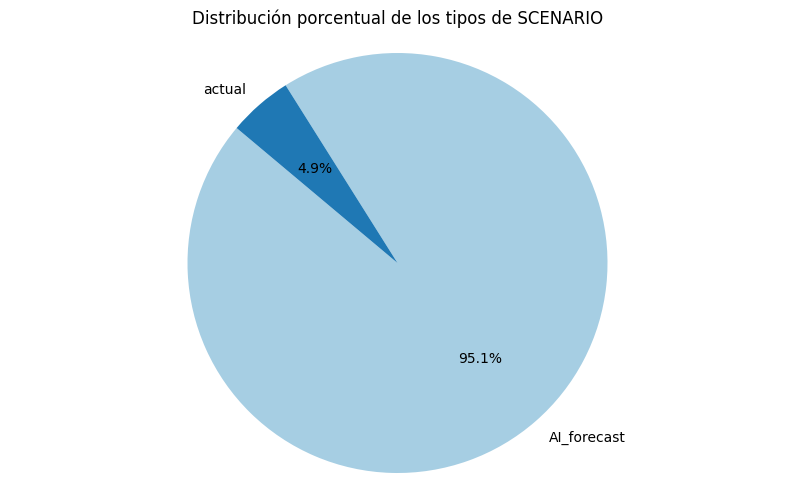

In [16]:
plt.figure(figsize=(10, 6))
plt.pie(conteo_escenarios, labels=conteo_escenarios.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

plt.title("Distribución porcentual de los tipos de SCENARIO")
plt.axis('equal')
plt.show()

Un 4.9% de los datos son actual.

Vemos con cuántos paises y cuáles son con los que contamos en la base de datos.

In [17]:
num_paises = df['COUNTRY'].nunique()

lista_paises = df['COUNTRY'].unique()

print(f"El número de países es: {num_paises}")
print("Los países son:", lista_paises)

El número de países es: 9
Los países son: ['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']


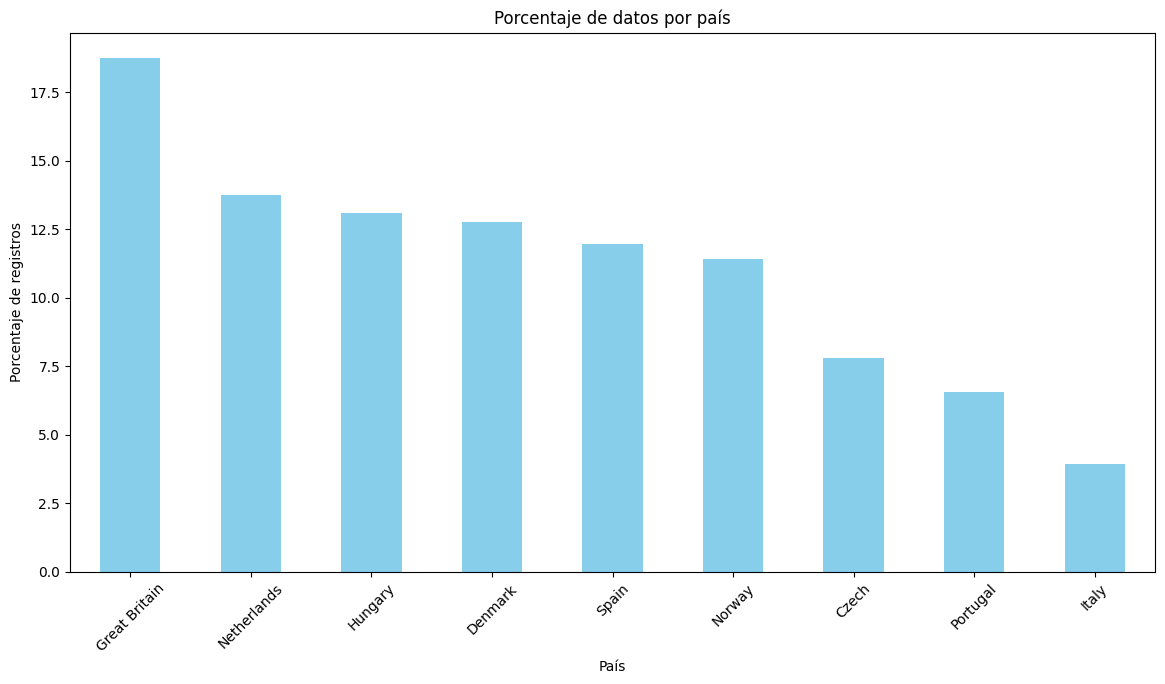

In [18]:
conteo_paises = df['COUNTRY'].value_counts(normalize=True) * 100

plt.figure(figsize=(14, 7))
conteo_paises.plot(kind='bar', color='skyblue')

plt.title("Porcentaje de datos por país")
plt.xlabel("País")
plt.ylabel("Porcentaje de registros")
plt.xticks(rotation=45)
plt.show()

Vemos como Great Britain es el país con el que más datos cuenta el dataframe mientras que Italia el que menos. Esto puede dar lugar a una interpretación limitada ya que si un país tiene un porcentaje de datos significativamente más alto que los demás, esto dificultaría la interpretación y comparación de los datos.

Además la atención se concentrará casi exclusivamente en el país con la barra más alta (Great Britain), y los demás países podrían parecer insignificantes en comparación.

Por ello, vamos a ver si en los escenarios con valores reales los países estan equilibrados.

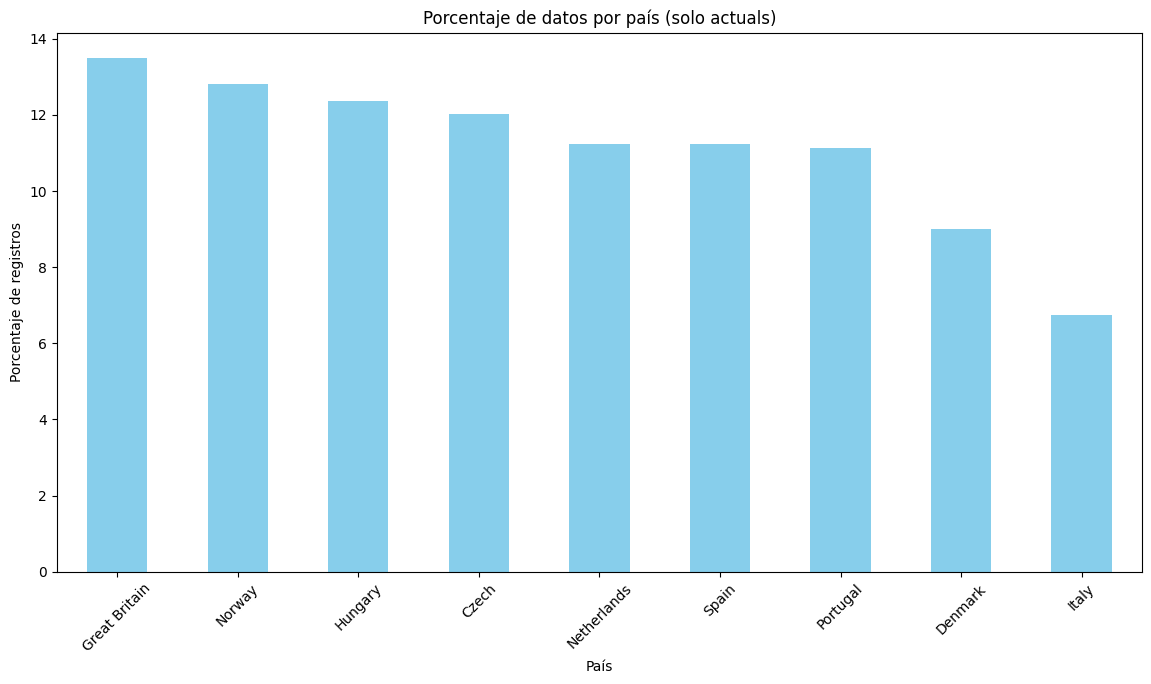

In [19]:
df_actuals = df[df['SCENARIO'].str.strip().str.lower() == 'actual']

conteo_paises_actuals = df_actuals['COUNTRY'].value_counts(normalize=True) * 100

plt.figure(figsize=(14, 7))
conteo_paises_actuals.plot(kind='bar', color='skyblue')

plt.title("Porcentaje de datos por país (solo actuals)")
plt.xlabel("País")
plt.ylabel("Porcentaje de registros")
plt.xticks(rotation=45)
plt.show()

Comprobamos que hay una gran diferencia respecto a la cantidad de datos en algunos casos como en el de Great Britain e Italy.

Agrupamos por paises y obtenemos el conjunto de bebidas que hay en cada país para ver si tienen las mismas marcas

In [20]:
bebidas_por_pais = df.groupby('COUNTRY')['SUBBRAND'].apply(set)
todas_las_bebidas = set(df['SUBBRAND'].unique())
mismo_bebidas = bebidas_por_pais.apply(lambda x: x == todas_las_bebidas)

if mismo_bebidas.all():
    print("Todos los países tienen las mismas bebidas.")
else:
    print("No todos los países tienen las mismas bebidas.")

No todos los países tienen las mismas bebidas.


###Cómo se distribuyen las ventas

Analizar cómo se distribuyen las ventas en cada país es fundamental en un análisis de ventas. Ya que puede ayudarnos a identificar cuáles son los países con mayor volumen de ventas y, por lo tanto, mercados clave para el negocio.

Vamos a tratar de realizar un mapa de calor sobre el mapa de Europa para comprobar qué paises tienen mayores ventas. Para ello, lo primero que debemos hacer es un idccionario de códigos ISO Alpha-3 que se basa en un estándar internacional de códigos de tres letras que identifica cada país en el mundo.

In [21]:
iso_codes = {
    'Czech': 'CZE',
    'Denmark': 'DNK',
    'Great Britain': 'GBR',
    'Hungary': 'HUN',
    'Italy': 'ITA',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Portugal': 'PRT',
    'Spain': 'ESP'
}

Una vez tenemos los ISO Alpha-3 sumaremos las ventas de cada país y crearemos el maapa de calor.

In [22]:
ventas_actual= df[df['SCENARIO'].str.strip().str.lower() == 'actual']
ventas_actuals_por_pais = ventas_actual.groupby('COUNTRY')['AMOUNT'].sum().reset_index()

ventas_actuals_por_pais['ISO3'] = ventas_actuals_por_pais['COUNTRY'].map(iso_codes)

fig = px.choropleth(
    ventas_actuals_por_pais,
    locations='ISO3',
    color='AMOUNT',
    hover_name='COUNTRY',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='europe'
)

fig.update_layout(title_text="Distribución de Ventas por país")

fig.show()


Podemos comprobar que el país con mayores ventas es 'Great Britain'y el país con menores ventas parece ser España, pero no sabemos el orden de los demás paises ya que tienen un color parecido, es decir que deben estar en el mismo rango de número de ventas. Por ello, realizaré un gráfico de barras para tratar de que se vea con mayor claridad.

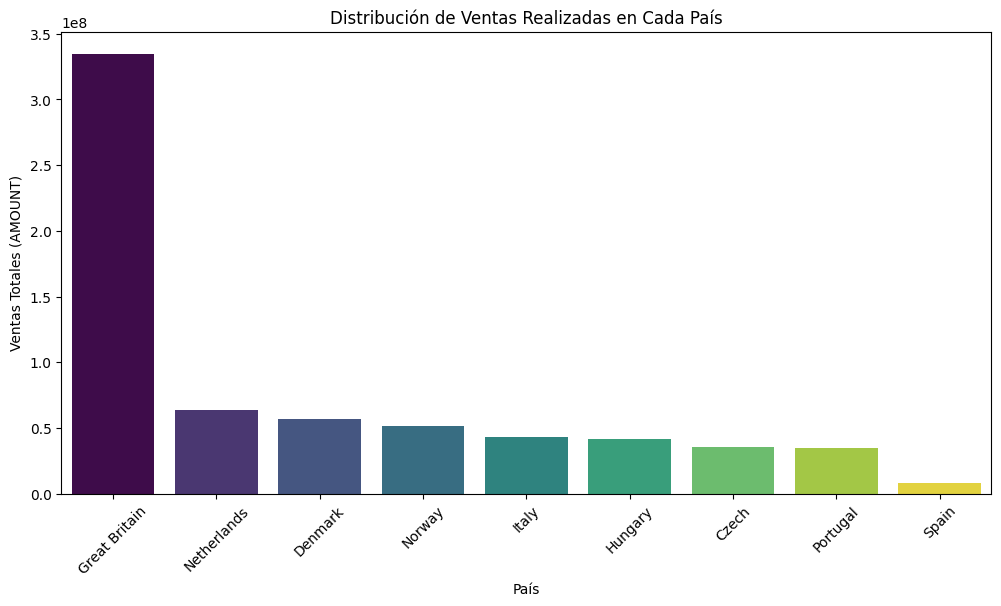

In [23]:
ventas_actuals_por_pais = ventas_actuals_por_pais.sort_values(by='AMOUNT', ascending=False)

unique_countries = ventas_actuals_por_pais['COUNTRY'].unique()
colors = cm.viridis(np.linspace(0, 1, len(unique_countries)))
color_dict = dict(zip(unique_countries, colors))

plt.figure(figsize=(12, 6))
sns.barplot(
    data=ventas_actuals_por_pais,
    x='COUNTRY',
    y='AMOUNT',
    hue='COUNTRY',
    dodge=False,
    palette=color_dict
)

plt.title("Distribución de Ventas Realizadas en Cada País")
plt.xlabel("País")
plt.ylabel("Ventas Totales (AMOUNT)")
plt.xticks(rotation=45)

plt.show()



De esta forma podemos asegurar que el país con menores ventas previstas es España y confirmar que Great Britain tiene notablemente mayores ventas, además sabemos el orden de los paises de mayor a menor distribución de la ventas realizadas de cada pais. Sin embargo, esto es con respecto a la base de datos y como ya hemos visto, no hay la misma cantidad de datos para todos los paises, por ello realizaremos lo mismo pero con porcentajes.

In [24]:
registros_actuals_por_pais = ventas_actual['COUNTRY'].value_counts(normalize=True).reset_index()
registros_actuals_por_pais.columns = ['COUNTRY', 'PERCENTAGE']

# Convertir el porcentaje a una escala de 0 a 100
registros_actuals_por_pais['PERCENTAGE'] *= 100

registros_actuals_por_pais['ISO3'] = registros_actuals_por_pais['COUNTRY'].map(iso_codes)

fig = px.choropleth(
    registros_actuals_por_pais,
    locations='ISO3',
    color='PERCENTAGE',
    hover_name='COUNTRY',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='europe'
)

fig.update_layout(title_text="Porcentaje de Datos Actuals por País")

fig.show()


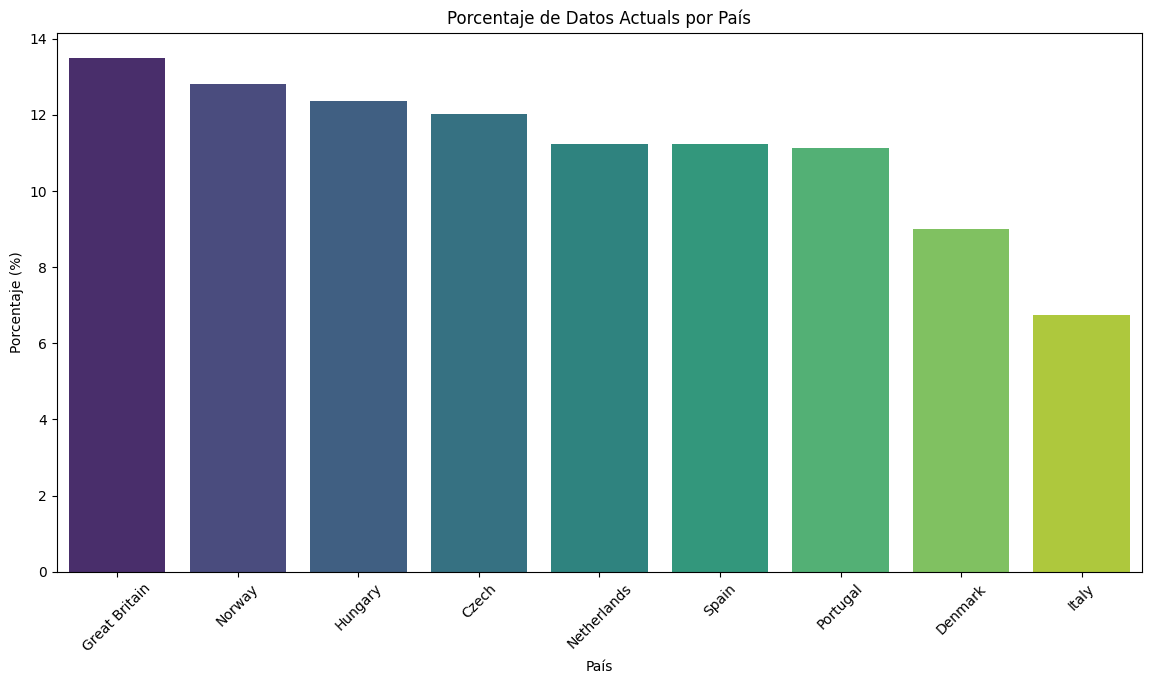

In [25]:
registros_actuals_por_pais = registros_actuals_por_pais.sort_values(by='PERCENTAGE', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(
    x='COUNTRY',
    y='PERCENTAGE',
    data=registros_actuals_por_pais,
    hue='COUNTRY',
    palette='viridis',
    dodge=False
)

plt.legend([], [], frameon=False)

plt.title('Porcentaje de Datos Actuals por País')
plt.xlabel('País')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45)

plt.show()


De esta forma nos damos cuenta de que en proporción realmente el País con menos ventas es Italia. Esta es una forma útil de visualizar qué países contribuyen más o menos en términos de ventas como proporción del total. Debemos tener en cuenta que este gráfico no muestra las ventas reales. En cambio, indica qué países tienen una mayor o menor cantidad de registros actuals en el dataset

Seguimos estudiando la distibución de las ventas en Portugal dependiendo del mes y el año. Para ello agruparemos por año y mes y sumaremos las ventas posteriormente, haremos un diagrama de línea para poder ver la tendencia de los datos.

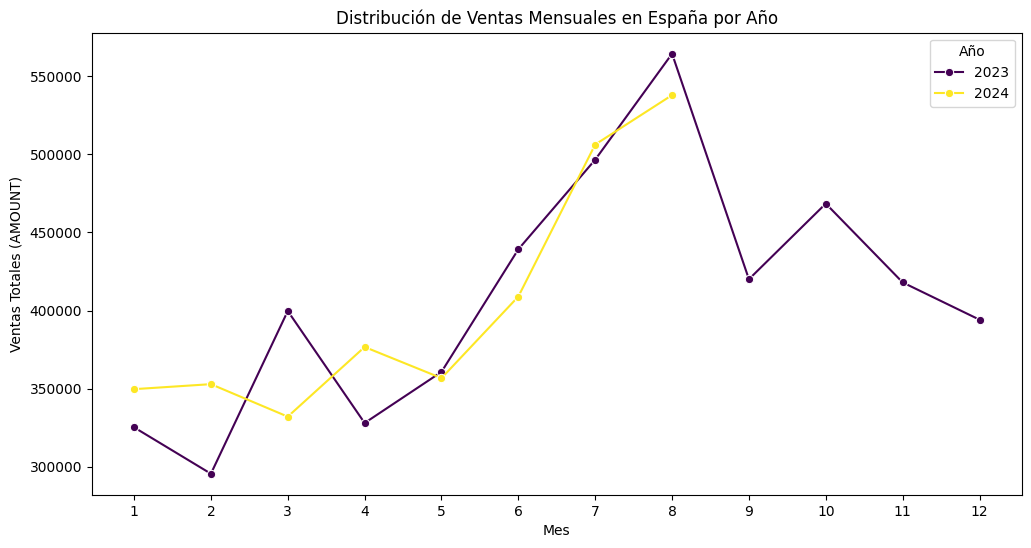

In [48]:
ventas_españa = df[df['SCENARIO'].str.strip().str.lower() == 'actual']

ventas_españa_actual = ventas_españa[ventas_españa['COUNTRY'] == 'Spain']

ventas_españa_mes_anio = ventas_españa_actual.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=ventas_españa_mes_anio, x='MONTH', y='AMOUNT', hue='YEAR', marker='o', palette='viridis')

plt.title("Distribución de Ventas Mensuales en España por Año")
plt.xlabel("Mes")
plt.ylabel("Ventas Totales (AMOUNT)")
plt.xticks(range(1, 13))
plt.legend(title="Año")
plt.show()

La gráfica muestra la distribución mensual de las ventas en España para los años 2023 y 2024.

Las ventas mensuales parecen seguir una tendencia de crecimiento desde enero hasta agosto, con un pico muy marcado en julio y agosto en ambos años.
Luego de alcanzar su punto máximo, las ventas caen en septiembre, y continúan descendiendo gradualmente hasta diciembre.

Las ventas de 2023 (línea morada) muestran una mayor volatilidad entre meses en comparación con 2024.
En 2024 (línea amarilla), las ventas presentan un crecimiento más constante y menos variable, aunque también alcanzan su punto máximo en julio y agosto, similar a 2023.

En los primeros meses (enero a abril), 2024 tiene ventas ligeramente superiores o similares a las de 2023.
Durante el pico de ventas (junio a agosto), 2023 alcanza niveles más altos que 2024.
A partir de septiembre, ambas líneas muestran una tendencia de disminución, aunque 2023 sigue con mayores ventas absolutas.

El comportamiento sugiere una estacionalidad anual, con un crecimiento sostenido hacia el verano (meses de verano en el hemisferio norte) y una caída en otoño e invierno.

Esta gráfica nos indica que el mercado de este país tiene ciclos anuales, donde las ventas aumentan en verano.

Estudiamos la distribuciones de las bebidas por mes. Para ello dividiremos las ventas en dos años 2023 y 2024 para ver si siguen algun patrón. Agrupamos las ventas con mes y marca y crearemos dos gráficos de barras donde podremos ver todas las ventas de cada marca al mes.

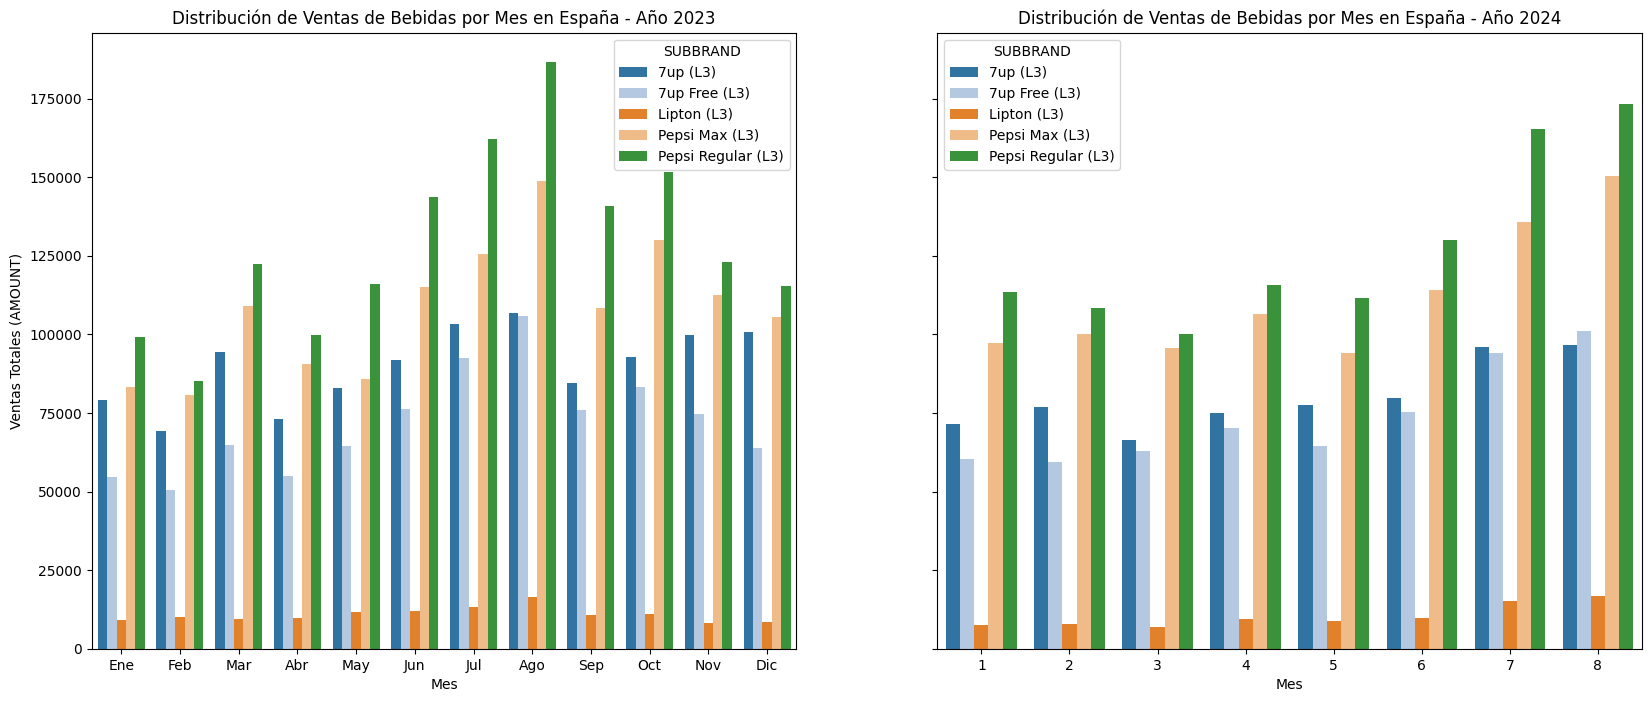

In [94]:
ventas_españa_bebida_actual = df[(df['COUNTRY'] == 'Spain') & (df['SCENARIO'].str.strip().str.lower() == 'actual')]

ventas_españa_bebida_mes_anio = ventas_españa_bebida_actual.groupby(['YEAR', 'MONTH', 'SUBBRAND'])['AMOUNT'].sum().reset_index()

ventas_españa_2023 = ventas_españa_bebida_mes_anio[ventas_españa_bebida_mes_anio['YEAR'] == 2023]
ventas_españa_2024 = ventas_españa_bebida_mes_anio[ventas_españa_bebida_mes_anio['YEAR'] == 2024]

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Gráfico de 2023
sns.barplot(data=ventas_españa_2023, x='MONTH', y='AMOUNT', hue='SUBBRAND', errorbar=None, palette='tab20', ax=axes[0])
axes[0].set_title("Distribución de Ventas de Bebidas por Mes en España - Año 2023")
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("Ventas Totales (AMOUNT)")
axes[0].set_xticks(range(0, 12))
axes[0].set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])

# Gráfico de 2024
sns.barplot(data=ventas_españa_2024, x='MONTH', y='AMOUNT', hue='SUBBRAND', errorbar=None, palette='tab20', ax=axes[1])
axes[1].set_title("Distribución de Ventas de Bebidas por Mes en España - Año 2024")
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("")


plt.show()


En ambos años, Pepsi Regular es consistentemente la bebida más vendida, especialmente en los meses de verano, alcanzando su punto máximo en agosto. Esto indica una preferencia notable por esta bebida en los meses cálidos.

Pepsi Max también presenta picos de ventas en verano, aunque generalmente tiene menores ventas comparado con Lipton.

7UP y 7UP tienen ventas más estables a lo largo del año y no muestran un pico tan pronunciado en verano, sugiriendo que su consumo es menos estacional.

Lipton es la bebida con ventas más bajas en comparación con las demás.

Una vez hemos visto la distribución de las ventas dependiendo de los meses y las marcas en 2023 y 2024 haremos un gráfico circular en el que se vea la distribución total de venta de las marcas más vendidas y las que menos.

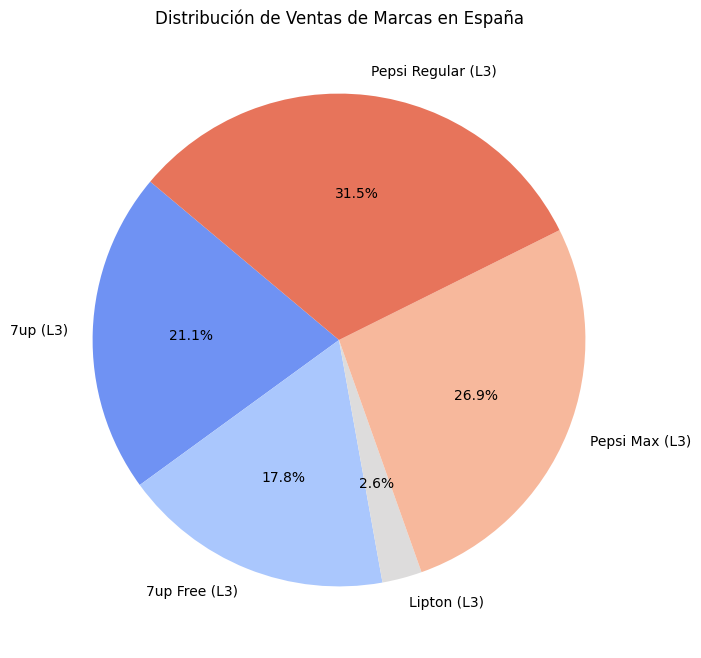

In [95]:
ventas_españa_por_bebida = ventas_españa_bebida_actual.groupby('SUBBRAND')['AMOUNT'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(ventas_españa_por_bebida['AMOUNT'], labels=ventas_españa_por_bebida['SUBBRAND'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('coolwarm', len(ventas_españa_por_bebida)))

plt.title("Distribución de Ventas de Marcas en España")
plt.show()

Pepsi Regular por tanto es una de las bebidas más vendidas seguida de Pepsi Max, 7up, 7up Free y Lipton.

###Análisis de ventas por paises

El primer paso que realizaremos será comprobar que paises tienen mayores ventas y la marca más vendida en ese país.

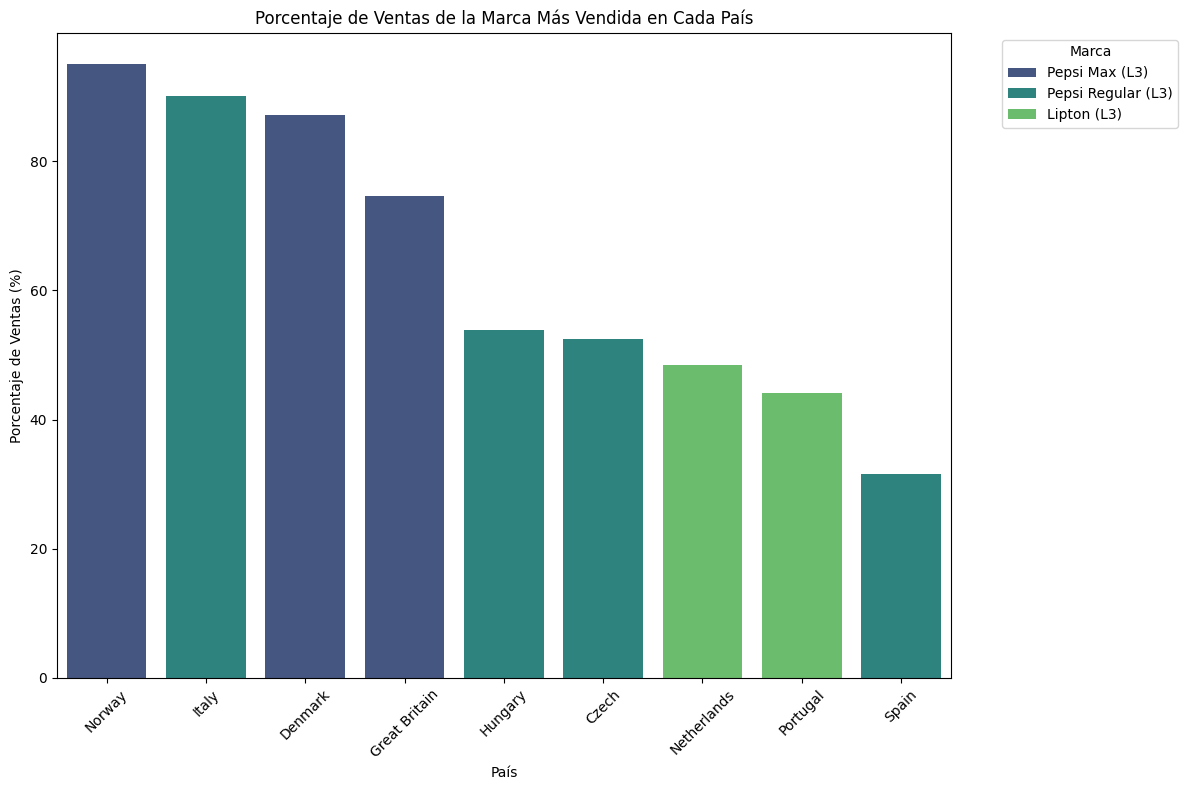

In [29]:
df_actual = df[df['SCENARIO'].str.strip().str.lower() == 'actual']
ventas_por_pais_y_marca = df_actual.groupby(['COUNTRY', 'SUBBRAND'])['AMOUNT'].sum().reset_index()
ventas_por_pais_y_marca = ventas_por_pais_y_marca.sort_values(['COUNTRY', 'AMOUNT'], ascending=[True, False])

marca_mas_vendida_por_pais = ventas_por_pais_y_marca.groupby('COUNTRY').first().reset_index()

total_ventas_por_pais = df_actual.groupby('COUNTRY')['AMOUNT'].sum().reset_index()
total_ventas_por_pais.rename(columns={'AMOUNT': 'TOTAL_AMOUNT'}, inplace=True)

# Unir el total de ventas al DataFrame de la marca más vendida
marca_mas_vendida_por_pais = marca_mas_vendida_por_pais.merge(total_ventas_por_pais, on='COUNTRY')

# Calcular el porcentaje de ventas de la marca más vendida
marca_mas_vendida_por_pais['PERCENTAGE'] = (marca_mas_vendida_por_pais['AMOUNT'] / marca_mas_vendida_por_pais['TOTAL_AMOUNT']) * 100

marca_mas_vendida_por_pais = marca_mas_vendida_por_pais.sort_values(by='PERCENTAGE', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=marca_mas_vendida_por_pais, x='COUNTRY', y='PERCENTAGE', hue='SUBBRAND', dodge=False, palette='viridis')

plt.title("Porcentaje de Ventas de la Marca Más Vendida en Cada País")
plt.xlabel("País")
plt.ylabel("Porcentaje de Ventas (%)")
plt.xticks(rotation=45)
plt.legend(title="Marca", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Vemos que Pepsi Regular, Pepsi Max y Lipton son las marcas líderes de algunos paises, y aunque el país con mayores ventas es Great Britain como habiamos visto antes, Norway es el pais que mas ventas de Pepsi Max tiene con respecto a el total de ventas que tiene (Vende al rededor de un 95% de Pepsi Max).


Ahora vemos la tendencia y estabilidad de Pepsi Max

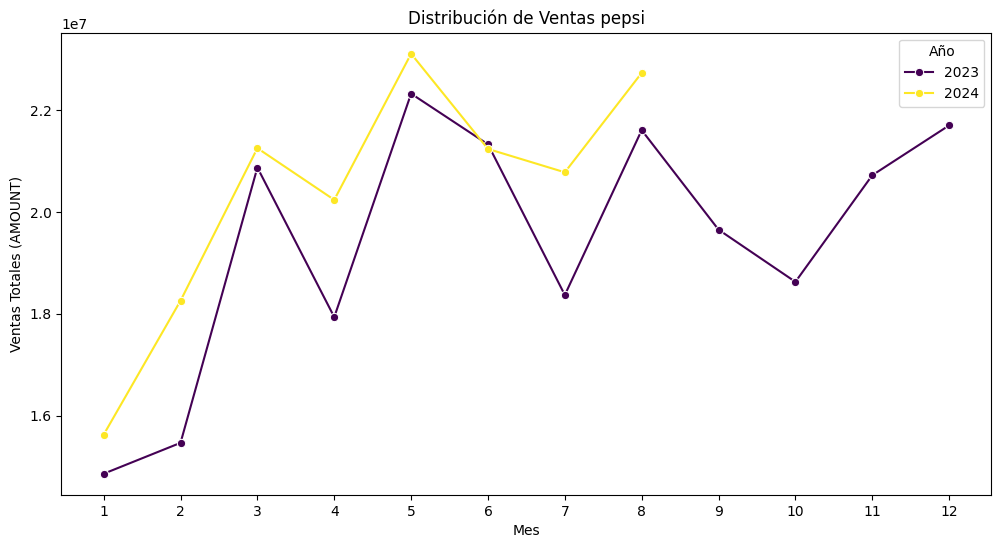

In [30]:
ventas_pepsi_actual = df[(df['SCENARIO'].str.strip().str.lower() == 'actual') &
                         (df['SUBBRAND'].str.strip().str.lower().str.contains('pepsi max'))]

ventas_pepsi_mes_anio = ventas_pepsi_actual.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=ventas_pepsi_mes_anio, x='MONTH', y='AMOUNT', hue='YEAR', marker='o', palette='viridis')

plt.title("Distribución de Ventas pepsi")
plt.xlabel("Mes")
plt.ylabel("Ventas Totales (AMOUNT)")
plt.xticks(range(1, 13))
plt.legend(title="Año")
plt.show()

En 2023 las ventas comienzan relativamente bajas en enero y muestran un crecimiento constante hasta alcanzar su pico más alto en mayo. Sin embargo, después de mayo, hay una caída significativa en julio y una recuperación en agosto. De agosto a octubre, se observa una disminución general en las ventas, aunque hay un leve repunte en los últimos meses del año (noviembre y diciembre).

Las ventas en 2024 también inician en un nivel bajo en enero, pero se observa un rápido crecimiento hasta alcanzar su máximo en mayo. Posteriormente, las ventas fluctúan entre mayo y agosto, con un pequeño descenso y recuperación.

Con respecto a la estabilidad, en ambos años, la estabilidad varía, ya que las ventas tienen picos y caídas en diferentes momentos del año. Esto indica que las ventas de "Pepsi" son algo volátiles y pueden estar influenciadas por factores estacionales, promociones, o eventos específicos.
Vamos a estudiar más en profundidad la tendencia y la estacionalidad.

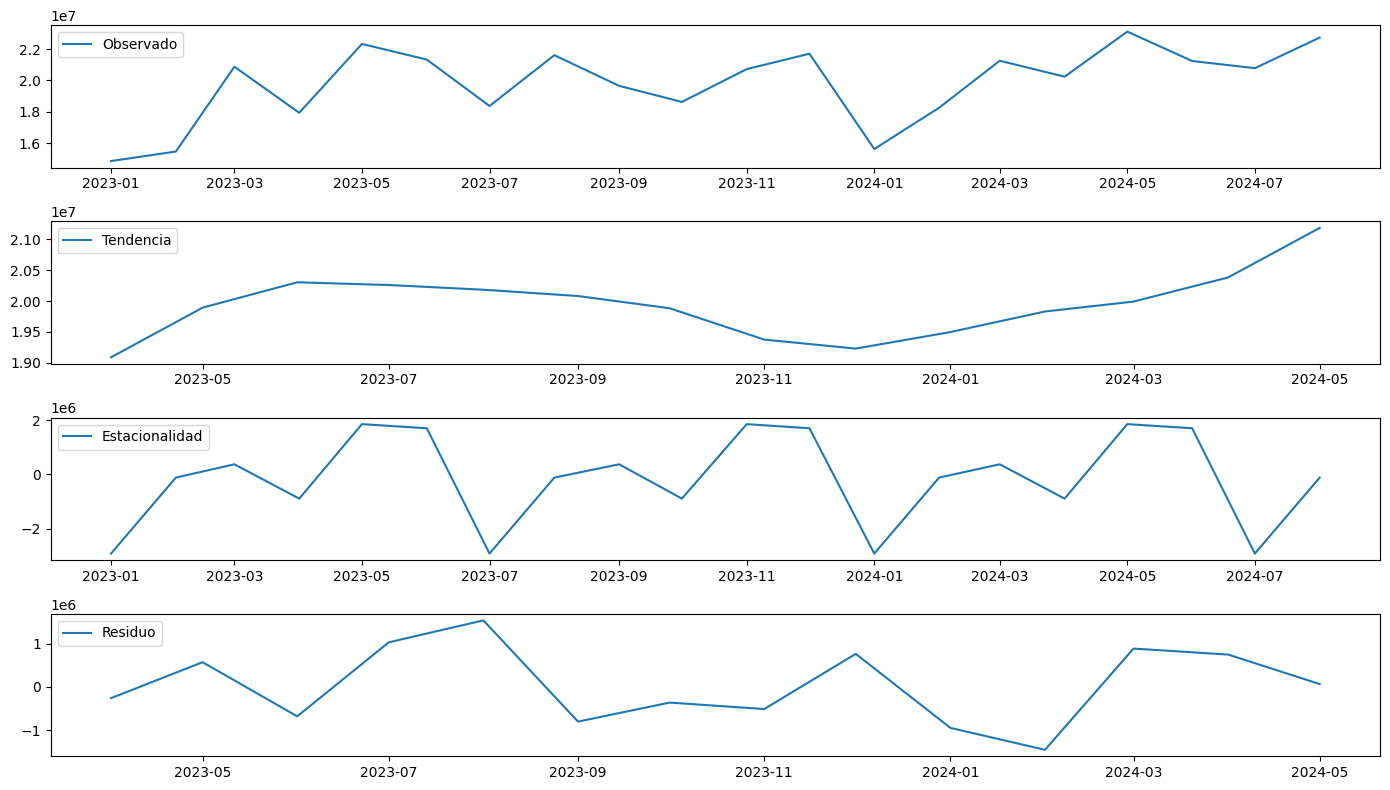

In [58]:
ventas_pepsi_actual = df[(df['SCENARIO'].str.strip().str.lower() == 'actual') &
                         (df['SUBBRAND'].str.strip().str.lower().str.contains('pepsi max'))]

ventas_pepsi_mes_anio = ventas_pepsi_actual.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()

ventas_pepsi_mes_anio['DATE'] = pd.to_datetime(ventas_pepsi_mes_anio[['YEAR', 'MONTH']].assign(DAY=1))
ventas_pepsi_mes_anio.set_index('DATE', inplace=True)

decomposition = seasonal_decompose(ventas_pepsi_mes_anio['AMOUNT'], model='additive', period=6)

plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

La gráfica de descomposición de la serie temporal muestra cuatro componentes clave para las ventas de Pepsi Max:

1. **Observado**:
   - Esta es la serie temporal original de las ventas mensuales.
   - Muestra una tendencia general de aumento de ventas con fluctuaciones a lo largo del tiempo.
   - Los picos en ventas se observan alrededor de mediados de cada año, mientras que algunas caídas ocurren entre los periodos.

2. **Tendencia**:
   - La tendencia subyacente muestra un aumento constante a lo largo del periodo.
   - Después de una leve caída a finales de 2023, las ventas vuelven a incrementar de forma sostenida durante 2024.
   - Esto indica que, a pesar de las fluctuaciones mensuales, la tendencia general es positiva, sugiriendo un crecimiento en las ventas a lo largo del tiempo.

3. **Estacionalidad**:
   - La componente estacional muestra un patrón cíclico repetitivo a lo largo de cada año.
   - Los valores altos y bajos de la estacionalidad parecen estar alineados con los picos y valles en el gráfico observado, indicando patrones de temporada que afectan las ventas.
   - Esto podría reflejar una estacionalidad en las ventas debido a factores como estaciones del año o eventos específicos.

4. **Residuo**:
   - La componente residual muestra las variaciones que no son explicadas por la tendencia ni la estacionalidad.
   - Aunque el residuo presenta algunas fluctuaciones, no parece haber un patrón claro.
   - Esto indica que la mayoría de las variaciones en las ventas son explicadas por la tendencia y la estacionalidad, y las desviaciones son aleatorias.

La serie temporal de ventas de Pepsi Max presenta una tendencia de crecimiento con una clara estacionalidad anual. Los picos de ventas en ciertos meses y las caídas en otros reflejan patrones predecibles en el consumo, lo cual es importante para planificar inventarios y estrategias de marketing. La tendencia positiva sugiere que el producto está ganando popularidad, mientras que la estacionalidad debe tenerse en cuenta para ajustar la oferta a la demanda cíclica.


Ahora analizaremos cuales son las marcas menos vendidas en los distintos paises.

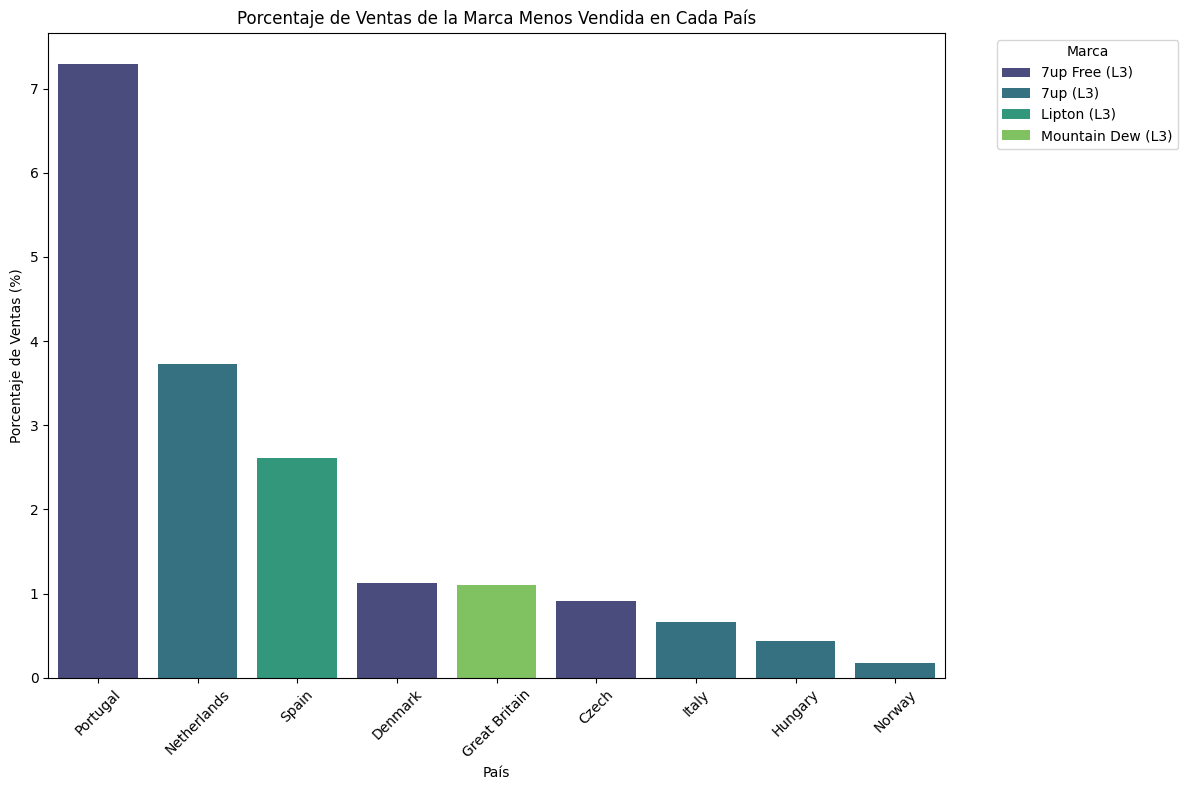

In [31]:
ventas_por_pais_y_marca = df_actual.groupby(['COUNTRY', 'SUBBRAND'])['AMOUNT'].sum().reset_index()
ventas_por_pais_y_marca = ventas_por_pais_y_marca.sort_values(['COUNTRY', 'AMOUNT'], ascending=[True, True])

marca_menos_vendida_por_pais = ventas_por_pais_y_marca.groupby('COUNTRY').first().reset_index()

total_ventas_por_pais = df_actual.groupby('COUNTRY')['AMOUNT'].sum().reset_index()
total_ventas_por_pais.rename(columns={'AMOUNT': 'TOTAL_AMOUNT'}, inplace=True)
marca_menos_vendida_por_pais = marca_menos_vendida_por_pais.merge(total_ventas_por_pais, on='COUNTRY')

marca_menos_vendida_por_pais['PERCENTAGE'] = (marca_menos_vendida_por_pais['AMOUNT'] / marca_menos_vendida_por_pais['TOTAL_AMOUNT']) * 100
marca_menos_vendida_por_pais = marca_menos_vendida_por_pais.sort_values(by='PERCENTAGE', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(data=marca_menos_vendida_por_pais, x='COUNTRY', y='PERCENTAGE', hue='SUBBRAND', dodge=False, palette='viridis')

plt.title("Porcentaje de Ventas de la Marca Menos Vendida en Cada País")
plt.xlabel("País")
plt.ylabel("Porcentaje de Ventas (%)")
plt.xticks(rotation=45)
plt.legend(title="Marca", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Con respecto al numero de ventas de cada pais estas son las marcas menos vendidas. Es decir, que Portugal, es el que más vende su marca menos vendida que en este caso es 7up Free.

Otra forma de representar las marcas menos vendidas en cada país es en un mapa.

In [32]:
color_map = {
    '7up Free (L3)': '#2F3E75',
    '7up (L3)': '#4C78A8',
    'Mountain Dew (L3)': '#54A24B',
    'Lipton (L3)': '#82C45A'
}

marca_menos_vendida_por_pais['ISO3'] = marca_menos_vendida_por_pais['COUNTRY'].map(iso_codes)

fig = px.choropleth(
    marca_menos_vendida_por_pais,
    locations='ISO3',
    color='SUBBRAND',
    hover_name='COUNTRY',
    hover_data={'SUBBRAND': True, 'AMOUNT': True},
    scope='europe',
    color_discrete_map=color_map
)

fig.update_layout(title_text="Marca Menos Vendida en Cada País")

fig.show()

Con este mapa podemos ver claramente cuales son las marcas menos vendidas y a que país pertenecen

###Predicciones en España

A continuación analizaremos las predicciones en España. Para ello, filtraremos los datos para obtener solo los de España, separaremos las predicciones de los valores reales y para poder realizar posteriormente una comparación los uniremos en otra variable.

Creamos un diccionario para mapear cada valor de FORECAST a un número de mes.

In [83]:
df = df[df['COUNTRY'] == 'Spain'].copy()

forecast_a_mes = {
    'AI_P02F': 2, 'AI_P03F': 3, 'AI_P04F': 4,
    'AI_P05F': 5, 'AI_P06F': 6, 'AI_P07F': 7,
    'AI_P08F': 8, 'AI_P09F': 9, 'AI_P10F': 10,
    'AI_P11F': 11, 'AI_P12F': 12, 'AI_PF': 1
}

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,MESPRED,PERIODO2,PERIODO,DISTANCIA_MESES
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,9,2023-09-01,2023-12-01,3.0
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023.0,134268.151080,5,2023-05-01,2023-12-01,7.0
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023.0,9702.217953,11,2023-11-01,2025-03-01,16.0
62,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023.0,70144.329753,4,2023-04-01,2024-01-01,9.0
68,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023.0,38882.921227,2,2023-02-01,2024-04-01,14.0


Creamos una columa con el mes que se realiza la predicción, correspondiente a cada valor de Forecast. Ademas, convertimos MesPred en valores numéricos asegurando que sean enteros y crearemos la columna PERIODO2

In [103]:
df['MESPRED'] = df['FORECAST'].map(forecast_a_mes)

df['MESPRED'] = pd.to_numeric(df['MESPRED'], errors='coerce').astype('Int64')

df['PERIODO2'] = pd.to_datetime(
    df['FORECAST_YEAR'].astype('Int64', errors='ignore').astype(str) + '-' +
    df['MESPRED'].fillna(1).astype(int).astype(str).str.zfill(2),
    errors='coerce'
)

df.loc[:, 'PERIODO'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str).str.zfill(2))

df.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,MESPRED,PERIODO2,PERIODO,DISTANCIA_MESES,CLOSEST_FORECAST,VALOR_PLOT
0,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,9,2023-09-01,2023-12-01,3.0,117473.978008,117473.978008
1,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023.0,134268.151080,5,2023-05-01,2023-12-01,7.0,139377.378566,139377.378566
2,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023.0,9702.217953,11,2023-11-01,2025-03-01,16.0,9959.985819,9959.985819
3,Spain,7up Free (L3),2024,1,AI_forecast,AI_P04F,2023.0,70144.329753,4,2023-04-01,2024-01-01,9.0,69248.965808,69248.965808
4,Spain,7up (L3),2024,4,AI_forecast,AI_P02F,2023.0,38882.921227,2,2023-02-01,2024-04-01,14.0,59781.430689,59781.430689


Como para una misma cosa, se hacen varias predicciones, nos quedaremos con la ultima predicción realizada, para esto restamos el periodo - periodo2

In [104]:
df['DISTANCIA_MESES'] = (
    (df['PERIODO'].dt.year - df['PERIODO2'].dt.year) * 12 +
    (df['PERIODO'].dt.month - df['PERIODO2'].dt.month)
)

print(df[['PERIODO', 'PERIODO2', 'DISTANCIA_MESES']])

        PERIODO   PERIODO2  DISTANCIA_MESES
0    2023-12-01 2023-09-01              3.0
1    2023-12-01 2023-05-01              7.0
2    2025-03-01 2023-11-01             16.0
3    2024-01-01 2023-04-01              9.0
4    2024-04-01 2023-02-01             14.0
...         ...        ...              ...
2147 2023-09-01        NaT              NaN
2148 2024-01-01 2023-07-01              6.0
2149 2024-10-01 2023-07-01             15.0
2150 2024-03-01 2023-09-01              6.0
2151 2024-12-01 2023-10-01             14.0

[2152 rows x 3 columns]


Ahora realizamos los gráficos de cada marca en los que se veran las predicciones y los actuals para poder hacernos una idea de como de bien/mal predigo. Para esto usamos la ultima predicción realizada como he dicho anteriormente.

In [102]:
min_distances = (
    df[df['SCENARIO'] == 'AI_forecast']
    .groupby(['COUNTRY', 'SUBBRAND', 'PERIODO'])['DISTANCIA_MESES']
    .min()
    .reset_index()
    .rename(columns={'DISTANCIA_MESES': 'MIN_DISTANCIA'})
)

closest_forecast = pd.merge(
    df[df['SCENARIO'] == 'AI_forecast'],
    min_distances,
    on=['COUNTRY', 'SUBBRAND', 'PERIODO']
)

closest_forecast = (
    closest_forecast[closest_forecast['DISTANCIA_MESES'] == closest_forecast['MIN_DISTANCIA']]
    .groupby(['COUNTRY', 'SUBBRAND', 'PERIODO'])
    .agg({'AMOUNT': 'mean'})
    .reset_index()
    .rename(columns={'AMOUNT': 'CLOSEST_FORECAST'})
)

# Unir las predicciones más cercanas al DataFrame de valores reales
df = pd.merge(
    df,
    closest_forecast,
    on=['COUNTRY', 'SUBBRAND', 'PERIODO'],
    how='left'
)

df['VALOR_PLOT'] = df.apply(
    lambda row: row['CLOSEST_FORECAST'] if row['SCENARIO'] == 'AI_forecast' else row['AMOUNT'],
    axis=1
)

fig = px.scatter(
    df,
    x='PERIODO',
    y='VALOR_PLOT',
    color='SCENARIO',
    facet_col='SUBBRAND',
    facet_col_wrap=2,
    title='Comparación de Ventas Real y Forecast (Más Cercano por Meses) por Sub-marca en España',
    labels={'VALOR_PLOT': 'Ventas', 'PERIODO': 'Fecha', 'SCENARIO': 'Tipo de Valor'}
)

fig.update_layout(
    legend_title_text='Tipo de Ventas',
    title_x=0.5,
    margin=dict(t=60, b=40, l=40, r=40),
    height=1200
)

fig.update_xaxes(matches=None, showticklabels=True)

fig.show()


Vamos a estudiar los errores de las predicciones, por un lado se estudiara el MAE(Error Absoluto Medio) y por otro lador el MAPE (Porcentaje de Error Absoluto Medio)

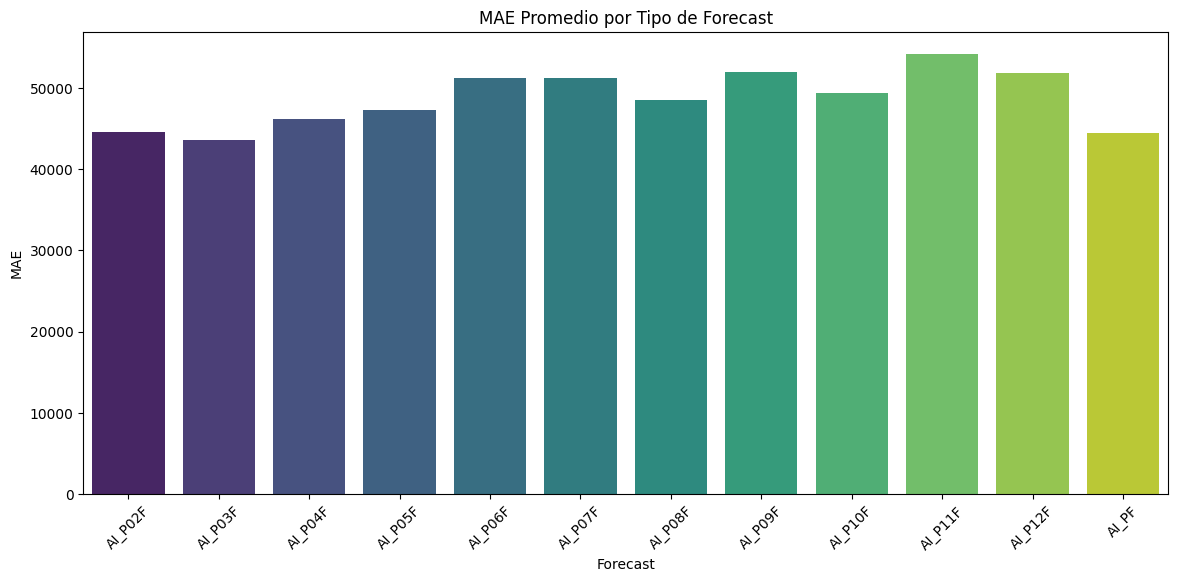

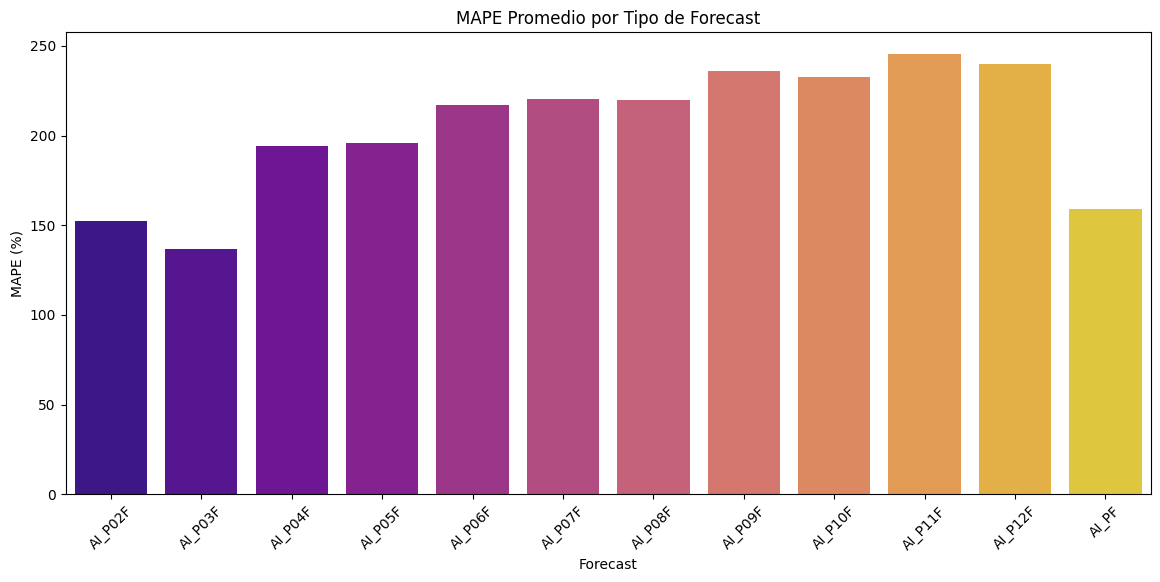

In [87]:
comparacion = pd.merge(predicciones_espana, reales_espana, on=['YEAR', 'MONTH'], suffixes=('_pred', '_real'))

# Calcular los errores en cada punto
comparacion['ABS_ERROR'] = abs(comparacion['AMOUNT_real'] - comparacion['AMOUNT_pred'])
comparacion['SQUARED_ERROR'] = (comparacion['AMOUNT_real'] - comparacion['AMOUNT_pred'])**2
comparacion['PERCENTAGE_ERROR'] = (comparacion['ABS_ERROR'] / comparacion['AMOUNT_real']) * 100
comparacion['PERCENTAGE_ERROR'] = comparacion['PERCENTAGE_ERROR'].replace([np.inf, -np.inf], np.nan).fillna(0)

errores_por_forecast = comparacion.groupby('FORECAST_pred').agg(
    MAE=('ABS_ERROR', 'mean'),
    RMSE=('SQUARED_ERROR', lambda x: np.sqrt(x.mean())),
    MAPE=('PERCENTAGE_ERROR', 'mean')
).reset_index()
#MAE
plt.figure(figsize=(14, 6))
sns.barplot(
    data=errores_por_forecast,
    x='FORECAST_pred',
    y='MAE',
    hue='FORECAST_pred',
    dodge=False,
    palette='viridis'
)
plt.title("MAE Promedio por Tipo de Forecast")
plt.xlabel("Forecast")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.show()

# Gráfico de MAPE
plt.figure(figsize=(14, 6))
sns.barplot(
    data=errores_por_forecast,
    x='FORECAST_pred',
    y='MAPE',
    hue='FORECAST_pred',
    dodge=False,
    palette='plasma'
)
plt.title("MAPE Promedio por Tipo de Forecast")
plt.xlabel("Forecast")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=45)
plt.show()



Comparación de los forecasts en el grafico de barras, por un lado tenemos el MAE. Un MAE más bajo es una indicación de un mejor rendimiento, ya que significa que el modelo predice los valores con menor desviación media respecto a los valores reales.
Gracias a esta representación podemos ver que los forecasts como AI_P02F, AI_P03F, y AI_P04F tienen MAE más bajos en comparación con otros, lo que indica que estos modelos son más precisos.
Por otro lado, los forecasts AI_P06F, AI_P09F, y AI_P11F tienen los MAE más altos, lo que sugiere que son menos precisos.

El MAPE refleja el error en términos porcentuales, lo que permite evaluar la precisión de cada forecast de manera relativa a los valores reales. Vemos que los forecasts AI_P02F, AI_P03F, y AI_PF tienen los valores de MAPE más bajos, lo que indica que estos modelos son más precisos y consistentes en términos relativos. Esto es positivo, ya que implica que estos modelos tienen un menor error porcentual promedio.
Los forecasts AI_P11F y AI_P12F tienen los valores de MAPE más altos, lo que sugiere que estos modelos presentan un mayor error relativo y son menos confiables en términos de predicciones porcentuales.

Ahora realizaremos un grafico de radar para ver qué forecast tiene un mejor equilibrio en las distintas métricas de error de forma más clara.

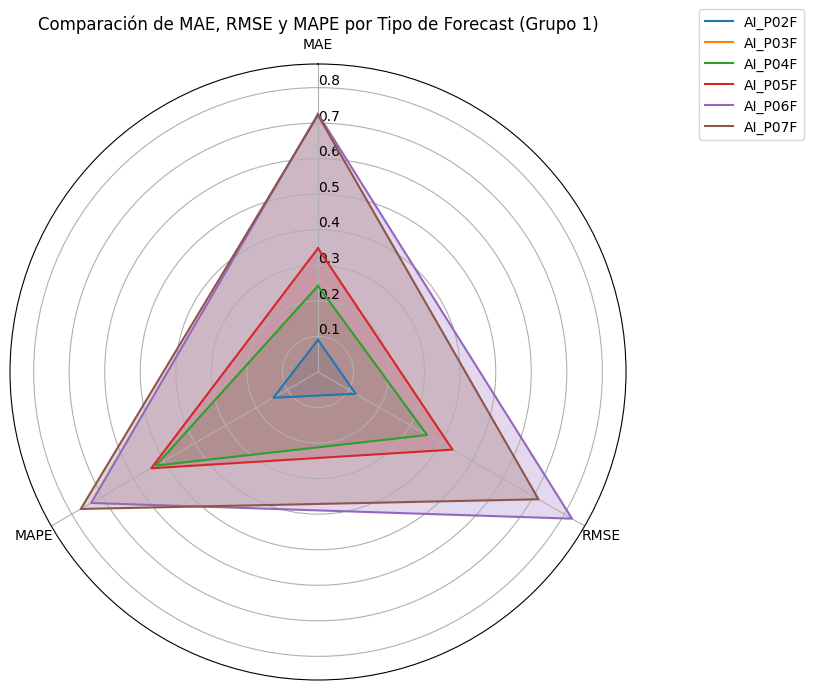

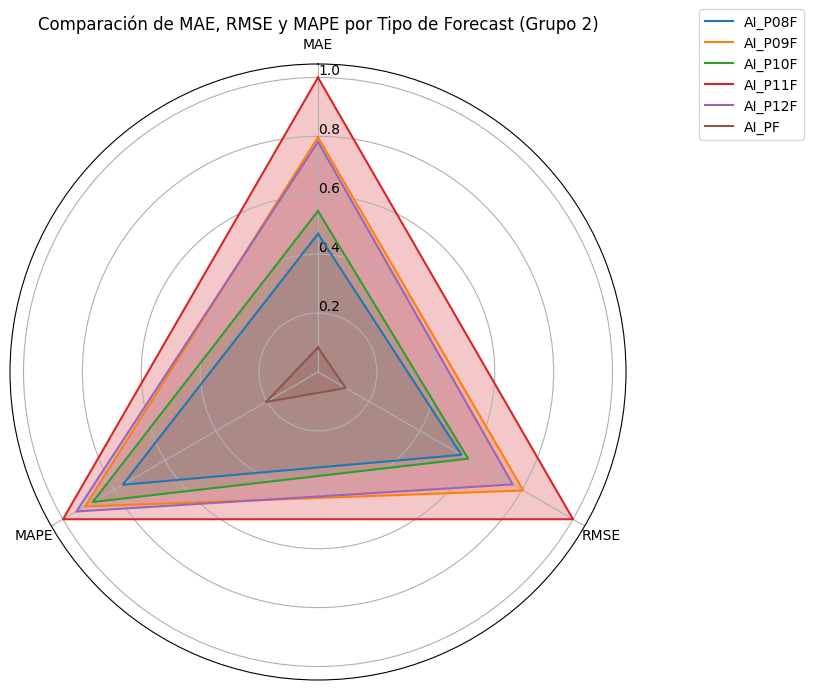

In [88]:
if 'FORECAST_pred' in errores_por_forecast.columns:
    categories = ['MAE', 'RMSE', 'MAPE']
    num_vars = len(categories)

    metrics_normalized = errores_por_forecast[categories]
    metrics_normalized = (metrics_normalized - metrics_normalized.min()) / (metrics_normalized.max() - metrics_normalized.min())
    metrics_normalized['FORECAST'] = errores_por_forecast['FORECAST_pred']

    # Dividir el DataFrame en dos subconjuntos
    mitad = len(metrics_normalized) // 2
    subset1 = metrics_normalized.iloc[:mitad]
    subset2 = metrics_normalized.iloc[mitad:]

    # Función para crear un gráfico de radar
    def plot_radar(subset, title):
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Cerrar el círculo

        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
        for index, row in subset.iterrows():
            values = row[categories].tolist()
            values += values[:1]  # Cerrar el círculo
            ax.plot(angles, values, label=row['FORECAST'])
            ax.fill(angles, values, alpha=0.25)

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_rlabel_position(0)
        plt.title(title)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.show()

    plot_radar(subset1, "Comparación de MAE, RMSE y MAPE por Tipo de Forecast (Grupo 1)")
    plot_radar(subset2, "Comparación de MAE, RMSE y MAPE por Tipo de Forecast (Grupo 2)")

else:
    print("La columna 'FORECAST_pred' no está presente en el DataFrame 'errores_por_forecast'.")


En un gráfico de radar, un área más pequeña y más centrada en el interior indica un mejor rendimiento, es decir, menores errores. Cuanto más alejadas estén las líneas del centro, mayor es el error.

Cada línea representa un tipo de forecast, y los vértices muestran los valores normalizados de cada métrica (MAE, RMSE y MAPE).

**Grupo 1 (primer gráfico):**

Los forecasts AI_P02F, AI_P03F, y AI_P04F tienen áreas más pequeñas en comparación con AI_P06F y AI_P07F, lo que sugiere que los primeros son más precisos.

AI_P06F y AI_P07F tienen un rendimiento peor, con áreas más grandes y alejadas del centro, indicando mayores valores de error.

**Grupo 2 (segundo gráfico):**

AI_PF es el forecast que parece tener un mejor rendimiento en este grupo, con un área más pequeña y centrada, lo que significa menores errores en todas las métricas.

Los forecasts AI_P11F y AI_P12F tienen áreas más grandes, lo que indica un peor rendimiento en comparación con otros en el mismo grupo.
AI_P08F, AI_P09F, y AI_P10F tienen resultados intermedios, con áreas moderadas.

Vamos a tomar de referencia el forecast AI_P02F y vamos a graficar lo que predijo vs lo que sucedió.

###HORIZONTE DE PRECISION


Ahora, respecto al forecast vamos a ver cuántas veces se ha hecho una predicción específica para un país y bebida específicos. En este caso, queremos saber cuántos meses tienen predicciones para el país Portugal y la bebida Lipton (L3) bajo el tipo de pronóstico "AI_P02F".

In [38]:
pais_especifico = "Portugal"
bebida_especifica = "Lipton (L3)"

conteo_forecast = df[(df['COUNTRY'] == pais_especifico) &
                      (df['SUBBRAND'] == bebida_especifica) &
                      (df['FORECAST'] == 'AI_P02F')].shape[0]

print(f"El número de meses que he predicho para {pais_especifico} y {bebida_especifica} es: {conteo_forecast}")

El número de meses que he predicho para Portugal y Lipton (L3) es: 18


Ahora vermos en un grafico como se distribuyen las predicciones con respecto al mes y año.

In [39]:
predicciones_filtradas = df[(df['COUNTRY'] == pais_especifico) &
                            (df['SUBBRAND'] == bebida_especifica) &
                            (df['FORECAST'] == 'AI_P02F')]


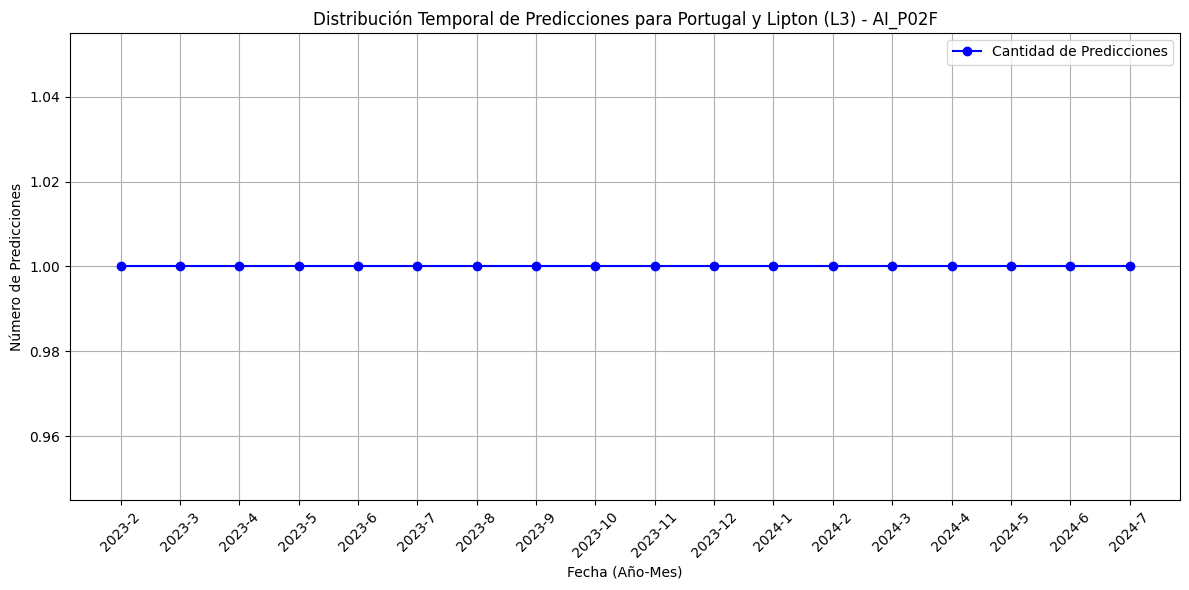

In [40]:
predicciones_por_mes = predicciones_filtradas.groupby(['YEAR', 'MONTH']).size().reset_index(name='COUNT')

predicciones_por_mes['Fecha'] = predicciones_por_mes['YEAR'].astype(str) + '-' + predicciones_por_mes['MONTH'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(predicciones_por_mes['Fecha'], predicciones_por_mes['COUNT'], marker='o', color='b', label='Cantidad de Predicciones')
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Número de Predicciones")
plt.title(f"Distribución Temporal de Predicciones para {pais_especifico} y {bebida_especifica} - AI_P02F")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Este gráfico nos muestra en qué meses y años se realizaron las predicciones para Portugal y Lipton (L3) bajo el forecast "AI_P02F". Vemos que las predicciones son constantes y se realiza una al mes, sin embargo esto parece poco habitual por lo que vamos a comprobarlo.

In [41]:
# Verificar los datos agrupados por mes
print("Datos agrupados por mes y año:")
print(predicciones_por_mes)


Datos agrupados por mes y año:
    YEAR  MONTH  COUNT    Fecha
0   2023      2      1   2023-2
1   2023      3      1   2023-3
2   2023      4      1   2023-4
3   2023      5      1   2023-5
4   2023      6      1   2023-6
5   2023      7      1   2023-7
6   2023      8      1   2023-8
7   2023      9      1   2023-9
8   2023     10      1  2023-10
9   2023     11      1  2023-11
10  2023     12      1  2023-12
11  2024      1      1   2024-1
12  2024      2      1   2024-2
13  2024      3      1   2024-3
14  2024      4      1   2024-4
15  2024      5      1   2024-5
16  2024      6      1   2024-6
17  2024      7      1   2024-7


In [42]:
print("Datos filtrados para Portugal, Lipton (L3), y AI_P02F:")
print(predicciones_filtradas[['YEAR', 'MONTH', 'FORECAST']])


Datos filtrados para Portugal, Lipton (L3), y AI_P02F:
       YEAR  MONTH FORECAST
0      2023     12  AI_P02F
742    2023      9  AI_P02F
953    2024      5  AI_P02F
2311   2023      5  AI_P02F
3353   2024      7  AI_P02F
4945   2023      2  AI_P02F
5667   2023      8  AI_P02F
6813   2023      3  AI_P02F
7152   2023     10  AI_P02F
9619   2024      2  AI_P02F
9620   2024      4  AI_P02F
12899  2023      4  AI_P02F
13033  2024      1  AI_P02F
13887  2024      6  AI_P02F
13989  2023      7  AI_P02F
14878  2023      6  AI_P02F
18579  2023     11  AI_P02F
18664  2024      3  AI_P02F


###CUANTOS FORECAST DISTINTOS TENGO

Comprobamos cuantos FORECAST tenemos y analizamos cuales son.

In [43]:
num_forecast_distintos = df['FORECAST'].nunique()
print(f"El número de tipos de forecast distintos es: {num_forecast_distintos}")


El número de tipos de forecast distintos es: 12


Vemos los distintos forecast que hay junto con su frecuencia

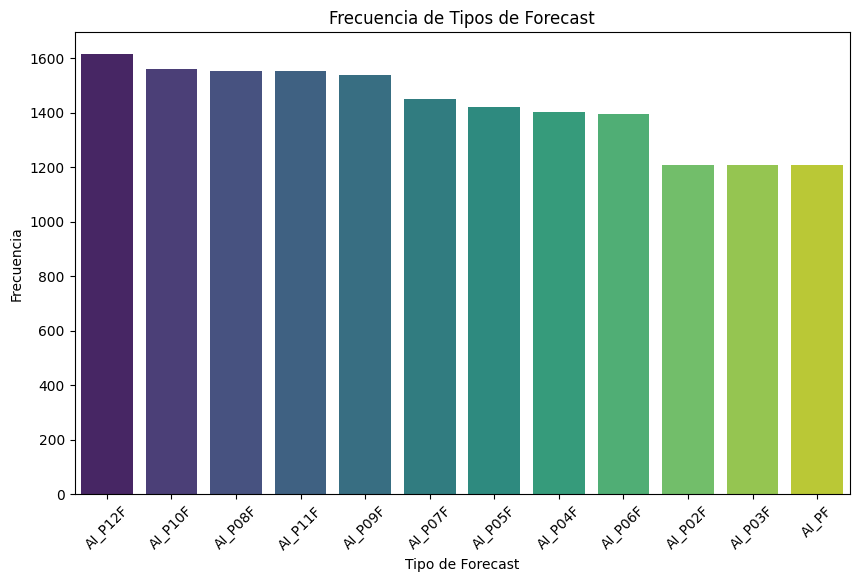

In [44]:
tipos_de_forecast = df['FORECAST'].value_counts().reset_index()
tipos_de_forecast.columns = ['FORECAST', 'FREQUENCY']

plt.figure(figsize=(10, 6))
sns.barplot(data=tipos_de_forecast, x='FORECAST', y='FREQUENCY', hue='FORECAST', palette='viridis', dodge=False, legend=False)

plt.title("Frecuencia de Tipos de Forecast")
plt.xlabel("Tipo de Forecast")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()
